In [1]:
import pandas as pd
import numpy as np
import os.path
import math
import collections
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import csv
import sys
import urllib

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn import tree
from sklearn.cross_validation import cross_val_score
from keras.utils import np_utils
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.svm import NuSVC

from sklearn.metrics import classification_report
from sklearn.calibration import CalibratedClassifierCV
from keras.utils import np_utils

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [3]:
season_2018_compact = pd.read_csv('./Stage2UpdatedDataFiles/RegularSeasonCompactResults.csv')
season_2018_detailed = pd.read_csv('./Stage2UpdatedDataFiles/RegularSeasonDetailedResults.csv')
tourney_2018_seeds = pd.read_csv('./Stage2UpdatedDataFiles/NCAATourneySeeds.csv')
submission_stage_2 = pd.read_csv('./SampleSubmissionStage2.csv')
teams_2018 = pd.read_csv('./Stage2UnchangedDataFiles/Teams.csv')
seasons = pd.read_csv('./DataFiles/Seasons.csv')
team_conferences = pd.read_csv('./DataFiles/TeamConferences.csv')

In [4]:
teamList = teams_2018['TeamName'].tolist() #A team list that will be used in later functions.

In [5]:
def check_Power6(team_id):
    team = team_conferences[(team_conferences['Season'] == 2018) & (team_conferences['TeamID'] == team_id)]
    # Can't find the team
    if (len(team) == 0):
        return 0
    conf_name = team.iloc[0]['ConfAbbrev']
    return int(conf_name == 'SEC' or conf_name == 'ACC'or conf_name == 'BIG_10' or conf_name == 'BIG_TWELVE' or conf_name == 'BIG_EAST' or conf_name == 'PAC_12')

def get_team_ID(name):
    return teams_2018[teams_2018['TeamName'] == name].values[0][0]

def get_team_name(team_id):
    return teams_2018[teams_2018['TeamID'] == team_id].values[0][1]

def list_for_URL(team_list):
    team_list = [x.lower() for x in team_list]
    team_list = [t.replace(' ', '-') for t in team_list]
    team_list = [t.replace('st', 'state') for t in team_list]
    team_list = [t.replace('northern-dakota', 'north-dakota') for t in team_list]
    team_list = [t.replace('nc-', 'north-carolina-') for t in team_list]
    team_list = [t.replace('fl-', 'florida-') for t in team_list]
    team_list = [t.replace('ga-', 'georgia-') for t in team_list]
    team_list = [t.replace('lsu', 'louisiana-state') for t in team_list]
    team_list = [t.replace('maristate', 'marist') for t in team_list]
    team_list = [t.replace('stateate', 'state') for t in team_list]
    team_list = [t.replace('northernorthern', 'northern') for t in team_list]
    team_list = [t.replace('usc', 'southern-california') for t in team_list]
    base = 'http://www.sports-reference.com/cbb/schools/'
    for team in team_list:
        url = base + team + '/'
list_for_URL(teamList);

def handle_cases(arr):
    indices = []
    list_len = len(arr)
    for i in range(list_len):
        if (arr[i] == 'St' or arr[i] == 'FL'):
            indices.append(i)
    for p in indices:
        arr[p-1] = arr[p-1] + ' ' + arr[p]
    for i in range(len(indices)):
        arr.remove(arr[indices[i] - i])
    return arr

def get_tourney_appearances(team_id):
    return len(tourney_2018_seeds[tourney_2018_seeds['TeamID'] == team_id].index)

def different_csv(df):
    # The stats CSV is a lit different in terms of naming so below is just some data cleaning
    df['School'] = df['School'].replace('(State)', 'St', regex=True)
    df['School'] = df['School'].replace('Albany (NY)', 'Albany NY')
    df['School'] = df['School'].replace('Boston University', 'Boston Univ')
    df['School'] = df['School'].replace('Central Michigan', 'C Michigan')
    df['School'] = df['School'].replace('(Eastern)', 'E', regex=True)
    df['School'] = df['School'].replace('Louisiana St', 'LSU')
    df['School'] = df['School'].replace('North Carolina St', 'NC State')
    df['School'] = df['School'].replace('Southern California', 'USC')
    df['School'] = df['School'].replace('University of California', 'California', regex=True)
    df['School'] = df['School'].replace('American', 'American Univ')
    df['School'] = df['School'].replace('Arkansas-Little Rock', 'Ark Little Rock')
    df['School'] = df['School'].replace('Arkansas-Pine Bluff', 'Ark Pine Bluff')
    df['School'] = df['School'].replace('Bowling Green St', 'Bowling Green')
    df['School'] = df['School'].replace('Brigham Young', 'BYU')
    df['School'] = df['School'].replace('Cal Poly', 'Cal Poly SLO')
    df['School'] = df['School'].replace('Centenary (LA)', 'Centenary')
    df['School'] = df['School'].replace('Central Connecticut St', 'Central Conn')
    df['School'] = df['School'].replace('Charleston Southern', 'Charleston So')
    df['School'] = df['School'].replace('Coastal Carolina', 'Coastal Car')
    df['School'] = df['School'].replace('College of Charleston', 'Col Charleston')
    df['School'] = df['School'].replace('Cal St Fullerton', 'CS Fullerton')
    df['School'] = df['School'].replace('Cal St Sacramento', 'CS Sacramento')
    df['School'] = df['School'].replace('Cal St Bakersfield', 'CS Bakersfield')
    df['School'] = df['School'].replace('Cal St Northridge', 'CS Northridge')
    df['School'] = df['School'].replace('East Tennessee St', 'ETSU')
    df['School'] = df['School'].replace('Detroit Mercy', 'Detroit')
    df['School'] = df['School'].replace('Fairleigh Dickinson', 'F Dickinson')
    df['School'] = df['School'].replace('Florida Atlantic', 'FL Atlantic')
    df['School'] = df['School'].replace('Florida Gulf Coast', 'FL Gulf Coast')
    df['School'] = df['School'].replace('Florida International', 'Florida Intl')
    df['School'] = df['School'].replace('George Washington', 'G Washington')
    df['School'] = df['School'].replace('Georgia Southern', 'Ga Southern')
    df['School'] = df['School'].replace('Gardner-Webb', 'Gardner Webb')
    df['School'] = df['School'].replace('Illinois-Chicago', 'IL Chicago')
    df['School'] = df['School'].replace('Kent St', 'Kent')
    df['School'] = df['School'].replace('Long Island University', 'Long Island')
    df['School'] = df['School'].replace('Loyola Marymount', 'Loy Marymount')
    df['School'] = df['School'].replace('Loyola (MD)', 'Loyola MD')
    df['School'] = df['School'].replace('Loyola (IL)', 'Loyola-Chicago')
    df['School'] = df['School'].replace('Massachusetts', 'MA Lowell')
    df['School'] = df['School'].replace('Maryland-Eastern Shore', 'MD E Shore')
    df['School'] = df['School'].replace('Miami (FL)', 'Miami FL')
    df['School'] = df['School'].replace('Miami (OH)', 'Miami OH')
    df['School'] = df['School'].replace('Missouri-Kansas City', 'Missouri KC')
    df['School'] = df['School'].replace('Monmouth', 'Monmouth NJ')
    df['School'] = df['School'].replace('Mississippi Valley St', 'MS Valley St')
    df['School'] = df['School'].replace('Montana St', 'MTSU')
    df['School'] = df['School'].replace('Northern Colorado', 'N Colorado')
    df['School'] = df['School'].replace('North Dakota St', 'N Dakota St')
    df['School'] = df['School'].replace('Northern Illinois', 'N Illinois')
    df['School'] = df['School'].replace('Northern Kentucky', 'N Kentucky')
    df['School'] = df['School'].replace('North Carolina A&T', 'NC A&T')
    df['School'] = df['School'].replace('North Carolina Central', 'NC Central')
    df['School'] = df['School'].replace('Pennsylvania', 'Penn')
    df['School'] = df['School'].replace('South Carolina St', 'S Carolina St')
    df['School'] = df['School'].replace('Southern Illinois', 'S Illinois')
    df['School'] = df['School'].replace('UC-Santa Barbara', 'Santa Barbara')
    df['School'] = df['School'].replace('Southeastern Louisiana', 'SE Louisiana')
    df['School'] = df['School'].replace('Southeast Missouri St', 'SE Missouri St')
    df['School'] = df['School'].replace('Stephen F. Austin', 'SF Austin')
    df['School'] = df['School'].replace('Southern Methodist', 'SMU')
    df['School'] = df['School'].replace('Southern Mississippi', 'Southern Miss')
    df['School'] = df['School'].replace('Southern', 'Southern Univ')
    df['School'] = df['School'].replace('St. Bonaventure', 'St Bonaventure')
    df['School'] = df['School'].replace('St. Francis (NY)', 'St Francis NY')
    df['School'] = df['School'].replace('Saint Francis (PA)', 'St Francis PA')
    df['School'] = df['School'].replace('St. John\'s (NY)', 'St John\'s')
    df['School'] = df['School'].replace('Saint Joseph\'s', 'St Joseph\'s PA')
    df['School'] = df['School'].replace('Saint Louis', 'St Louis')
    df['School'] = df['School'].replace('Saint Mary\'s (CA)', 'St Mary\'s CA')
    df['School'] = df['School'].replace('Mount Saint Mary\'s', 'Mt St Mary\'s')
    df['School'] = df['School'].replace('Saint Peter\'s', 'St Peter\'s')
    df['School'] = df['School'].replace('Texas A&M-Corpus Christian', 'TAM C. Christian')
    df['School'] = df['School'].replace('Texas Christian', 'TCU')
    df['School'] = df['School'].replace('Tennessee-Martin', 'TN Martin')
    df['School'] = df['School'].replace('Texas-Rio Grande Valley', 'UTRGV')
    df['School'] = df['School'].replace('Texas Southern', 'TX Southern')
    df['School'] = df['School'].replace('Alabama-Birmingham', 'UAB')
    df['School'] = df['School'].replace('UC-Davis', 'UC Davis')
    df['School'] = df['School'].replace('UC-Irvine', 'UC Irvine')
    df['School'] = df['School'].replace('UC-Riverside', 'UC Riverside')
    df['School'] = df['School'].replace('Central Florida', 'UCF')
    df['School'] = df['School'].replace('Louisiana-Lafayette', 'ULL')
    df['School'] = df['School'].replace('Louisiana-Monroe', 'ULM')
    df['School'] = df['School'].replace('Maryland-Baltimore County', 'UMBC')
    df['School'] = df['School'].replace('North Carolina-Asheville', 'UNC Asheville')
    df['School'] = df['School'].replace('North Carolina-Greensboro', 'UNC Greensboro')
    df['School'] = df['School'].replace('North Carolina-Wilmington', 'UNC Wilmington')
    df['School'] = df['School'].replace('Nevada-Las Vegas', 'UNLV')
    df['School'] = df['School'].replace('Texas-Arlington', 'UT Arlington')
    df['School'] = df['School'].replace('Texas-San Antonio', 'UT San Antonio')
    df['School'] = df['School'].replace('Texas-El Paso', 'UTEP')
    df['School'] = df['School'].replace('Virginia Commonwealth', 'VA Commonwealth')
    df['School'] = df['School'].replace('Western Carolina', 'W Carolina')
    df['School'] = df['School'].replace('Western Illinois', 'W Illinois')
    df['School'] = df['School'].replace('Western Kentucky', 'WKU')
    df['School'] = df['School'].replace('Western Michigan', 'W Michigan')
    df['School'] = df['School'].replace('Abilene Christian', 'Abilene Chr')
    df['School'] = df['School'].replace('Montana State', 'Montana St')
    df['School'] = df['School'].replace('Central Arkansas', 'Cent Arkansas')
    df['School'] = df['School'].replace('Houston Baptist', 'Houston Bap')
    df['School'] = df['School'].replace('South Dakota St', 'S Dakota St')
    df['School'] = df['School'].replace('Maryland-Eastern Shore', 'MD E Shore')
    return df

def home_advantage(row):
    if (row == 'H'):
        home = 1
    if (row == 'A'):
        home = -1
    if (row == 'N'):
        home = 0
    return home

def compare(id_1, id_2, year):
    team_1 = get_season_data(id_1, year)
    team_2 = get_season_data(id_2, year)
    diff = [a - b for a, b in zip(team_1, team_2)]
    return diff

def input_normalizer(arr):
    for i in range(arr.shape[1]):
        min_val = min(arr[:,i])
        max_val = max(arr[:,i])
        arr[:,i] =  (arr[:,i] - min_val) / (max_val - min_val)
    return arr

def input_normalizer_2(X):
    return (X - np.mean(X, axis = 0)) / np.std(X, axis = 0)

In [6]:
def get_season_data(team_id, year):
    # The data frame below holds stats for every single game in the given year
    year_data_2018 = season_2018_compact[season_2018_compact['Season'] == year]
    # Finding number of points per game
    games_won = year_data_2018[year_data_2018.WTeamID == team_id] 
    total_points_scored = games_won['WScore'].sum()
    games_lost = year_data_2018[year_data_2018.LTeamID == team_id] 
    total_games = games_won.append(games_lost)
    num_games = len(total_games.index)
    total_points_scored += games_lost['LScore'].sum()
    
    # Finding number of points per game allowed
    total_points_allowed = games_won['LScore'].sum()
    total_points_allowed += games_lost['WScore'].sum()
    
    #Result of data from http://www.sports-reference.com/cbb
    stats_SOS = pd.read_csv('./MM_Stats/MM_Stats_'+str(year)+'.csv')
    stats_SOS = different_csv(stats_SOS)
    rankings = pd.read_csv('./Rankings/Rankings_'+str(year)+'.csv')
    rankings = different_csv(rankings)
    
    name = get_team_name(team_id)
    team = stats_SOS[stats_SOS['School'] == name]
    team_ranking = rankings[rankings['School'] == name]
    if (len(team.index) == 0 or len(team_ranking.index) == 0): #Can't find the team
        total_3s_made = 0
        total_turnovers = 0
        total_assists = 0
        sos = 0
        total_rebounds = 0
        srs = 0
        total_steals = 0
    else:
        total_3s_made = team['X3P'].values[0]
        total_turnovers = team['TOV'].values[0]
        if (math.isnan(total_turnovers)):
            total_turnovers = 0
        total_assists = team['AST'].values[0]
        if (math.isnan(total_assists)):
            total_assists = 0
        sos = team['SOS'].values[0]
        srs = team['SRS'].values[0]
        total_rebounds = team['TRB'].values[0]
        if (math.isnan(total_rebounds)):
            total_rebounds = 0
        total_steals = team['STL'].values[0]
        if (math.isnan(total_steals)):
            total_steals = 0
    
    #Finding tournament seed for that year
    tourney_year = tourney_2018_seeds[tourney_2018_seeds['Season'] == year]
    seed = tourney_year[tourney_year['TeamID'] == team_id]
    if (len(seed.index) != 0):
        seed = seed.values[0][1]
        tournament_seed = int(seed[1:3])
    else:
        tournament_seed = 25 #Not sure how to represent if a team didn't make the tourney
    
    # Finding number of wins and losses
    num_wins = len(games_won.index)
    # There are some teams who may have dropped to Division 2, so they won't have games 
    # a certain year. In this case, we don't want to divide by 0, so we'll just set the
    # averages to 0 instead
    if num_games == 0:
        avg_points_scored = 0
        avg_points_allowed = 0
        avg_3s_made = 0
        avg_turnovers = 0
        avg_assists = 0
        avg_rebounds = 0
        avg_steals = 0
    else:
        avg_points_scored = total_points_scored/num_games
        avg_points_allowed = total_points_allowed/num_games
        avg_3s_made = total_3s_made/num_games
        avg_turnovers = total_turnovers/num_games
        avg_assists = total_assists/num_games
        avg_rebounds = total_rebounds/num_games
        avg_steals = total_steals/num_games
    return [num_wins, avg_points_scored, avg_points_allowed, check_Power6(team_id), avg_3s_made, avg_assists, avg_turnovers,
           tournament_seed, sos, srs, avg_rebounds, avg_steals, get_tourney_appearances(team_id)]

def create_season_dict(year):
    season_dictionary = collections.defaultdict(list)
    for team in teamList:
        team_id = teams_2018[teams_2018['TeamName'] == team].values[0][0]
        team_vector = get_season_data(team_id, year)
        season_dictionary[team_id] = team_vector
    return season_dictionary

def train_test(years, save_years):
    total_num_games = 0
    for year in years:
        season = season_2018_compact[season_2018_compact['Season'] == year]
        total_num_games += len(season.index)
        tourney = tourney_compact[tourney_compact['Season'] == year]
        total_num_games += len(tourney.index)
    num_features = len(get_season_data(1171,2016)) #Just choosing a random team and seeing the dimensionality of the vector
    xTrain = np.zeros(( total_num_games, num_features + 1))
    yTrain = np.zeros(( total_num_games ))
    index_counter = 0
    for year in years:
        team_vectors = create_season_dict(year)
        season = season_2018_compact[season_2018_compact['Season'] == year]
        num_games_in_season = len(season.index)
        tourney = tourney_compact[tourney_compact['Season'] == year]
        num_games_in_season += len(tourney.index)
        xTrainSeason = np.zeros(( num_games_in_season, num_features + 1))
        yTrainSeason = np.zeros(( num_games_in_season ))
        counter = 0
        for index, row in season.iterrows():
            winning_team = row['WTeamID']
            winning_vector = team_vectors[winning_team]
            losing_team = row['LTeamID']
            losing_vector = team_vectors[losing_team]
            diff = [a - b for a, b in zip(winning_vector, losing_vector)]
            home = home_advantage(row['WLoc'])
            if (counter % 2 == 0):
                diff.append(home) 
                xTrainSeason[counter] = diff
                yTrainSeason[counter] = 1
            else:
                diff.append(-home)
                xTrainSeason[counter] = [ -p for p in diff]
                yTrainSeason[counter] = 0
            counter += 1
        for index, row in tourney.iterrows():
            winning_team = row['WTeamID']
            winning_vector = team_vectors[winning_team]
            losing_team = row['LTeamID']
            losing_vector = team_vectors[losing_team]
            diff = [a - b for a, b in zip(winning_vector, losing_vector)]
            home = 0 #All tournament games are neutral
            if (counter % 2 == 0):
                diff.append(home) 
                xTrainSeason[counter] = diff
                yTrainSeason[counter] = 1
            else:
                diff.append(-home)
                xTrainSeason[counter] = [ -p for p in diff]
                yTrainSeason[counter] = 0
            counter += 1
        xTrain[index_counter:num_games_in_season+index_counter] = xTrainSeason
        yTrain[index_counter:num_games_in_season+index_counter] = yTrainSeason
        index_counter += num_games_in_season
        print ('Finished year:', year)
        if (year in save_years):
            np.save('./Team_Vectors/' + str(year) + 'TeamVectors', team_vectors)
    return xTrain, yTrain

def create_save(years, save_years):
    xTrain, yTrain = train_test(years, save_years)
    np.save('./xTrain_2018.npy', xTrain)
    np.save('./yTrain_2018.npy', yTrain)

In [7]:
years = range(1993,2019)
# Saves the team vectors for the following years
save_years = range(2014,2019)
if os.path.exists("./xTrain_2018.npy") and os.path.exists("./yTrain_2018.npy"):
    print ('There is already a precomputed xTrain and yTrain.')
    response = input('Do you want to remove these files and create a new training set? (y/n) ')
    if (response == 'y'):
        os.remove("./xTrain_2018.npy")
        os.remove("./yTrain_2018.npy")
        create_save(years, save_years)
    else: 
        print ('Okay, going to exit now.')
else:
    create_save(years, save_years)

There is already a precomputed xTrain and yTrain.
Do you want to remove these files and create a new training set? (y/n) n
Okay, going to exit now.


In [8]:
if os.path.exists("./xTrain_2018.npy") and os.path.exists("./yTrain_2018.npy"):
    xTrain = np.load("./xTrain_2018.npy")
    yTrain = np.load("./yTrain_2018.npy")
    print ("Shape of xTrain:", xTrain.shape)
    print ("Shape of yTrain:", yTrain.shape)
else:
    print ('We need a training set!')
    sys.exit()

Shape of xTrain: (125980, 14)
Shape of yTrain: (125980,)


## L2

Finished run #0. Accuracy = 0.7589141133513256
Finished run #1. Accuracy = 0.7633275123035402
Finished run #2. Accuracy = 0.7614224480076203
Finished run #3. Accuracy = 0.760596920146055
Finished run #4. Accuracy = 0.7626924908715669
Finished run #5. Accuracy = 0.7607239244324496
Finished run #6. Accuracy = 0.7622162247975869
Finished run #7. Accuracy = 0.7603746626448643
Finished run #8. Accuracy = 0.7603746626448643
Finished run #9. Accuracy = 0.760501666931259
Finished run #10. Accuracy = 0.7607239244324496
Finished run #11. Accuracy = 0.7612954437212256
Finished run #12. Accuracy = 0.758406096205747
Finished run #13. Accuracy = 0.7601841562152722
Finished run #14. Accuracy = 0.7634227655183362
Finished run #15. Accuracy = 0.7602476583584696
The average accuracy is:  0.7609640419114145
Loaded the team vectors


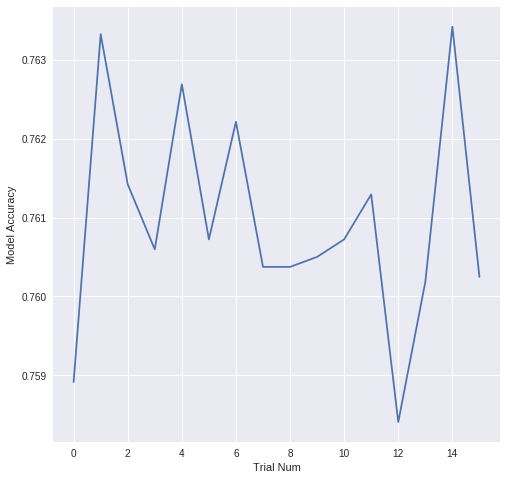

In [9]:
model = LogisticRegression(penalty='l2', C=1.0, dual=True, tol=0.000001, max_iter=1500, random_state=42)

categories=['Wins','PPG','PPGA','PowerConf','3PG', 'APG','TOP','Seed','SOS',\
            'SRS', 'RPG', 'SPG', 'Tourney Appearances','Location']
accuracy=[]
num_trials = 16

for i in range(num_trials):
    X_train, X_test, y_train, y_test = train_test_split(xTrain, yTrain)
    results = model.fit(X_train, y_train)
    preds = model.predict(X_test)

    preds[preds < .5] = 0
    preds[preds >= .5] = 1
    local_accuracy = np.mean(preds == y_test)
    accuracy.append(local_accuracy)
    print("Finished run #" + str(i) + ". Accuracy = " + str(local_accuracy))
print("The average accuracy is: ", sum(accuracy)/len(accuracy))

#Plot the accuracy.
plt.figure(figsize=(8, 8))
plt.plot(accuracy)
plt.xlabel("Trial Num")
plt.ylabel("Model Accuracy")

def predict_game(team_1_vector, team_2_vector, home):
    diff = [a - b for a, b in zip(team_1_vector, team_2_vector)]
    diff.append(home)
    # Depending on the model you use, you will either need to return model.predict_proba or model.predict
    # predict_proba = Linear Reg, Linear SVC
    # predict = Gradient Boosted

    return model.predict_proba([diff])[0][1]
    #return model.predict([diff])[0]
    
def load_team_vectors(years):
    list_dictionaries = []
    for year in years:
        current_vectors = np.load("./Team_Vectors/" + str(year) + "TeamVectors.npy").item()
        list_dictionaries.append(current_vectors)
    return list_dictionaries

def create_prediction(stage_2 = False):
    #this will allow us to submit predictions for just 2018
    if stage_2:
        
        years = [2018]
        new_submission = submission_stage_2
    #this will allow us to submit predictions for 2014-2017  
    else:
        years = range(2014, 2018)
        new_submission = submission
    
    if os.path.exists("result.csv"):
        os.remove("result.csv")
    
    list_dictionaries = load_team_vectors(years)
    print ("Loaded the team vectors")
    results = [[0 for x in range(2)] for x in range(len(new_submission.index))]
    
    for index, row in new_submission.iterrows():
        matchup = row['ID']
        year = int(matchup[0:4])
        team_vectors = list_dictionaries[year - years[0]]
        team_1_ID = int(matchup[5:9])
        team_2_ID = int(matchup[10:14])
        team_1_vector = team_vectors[team_1_ID]
        team_2_vector = team_vectors[team_2_ID]
        pred = predict_game(team_1_vector, team_2_vector, 0)
        results[index][0] = matchup
        results[index][1] = pred
    results = pd.np.array(results)
    first_row = [[0 for x in range(2)] for x in range(1)]
    first_row[0][0] = 'ID'
    first_row[0][1] = 'Pred'
    with open("result_l2_2018.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(first_row)
        writer.writerows(results)

create_prediction(stage_2=True)

## Linear SVC

Finished run #0. Accuracy = 0.7613906969360216
Finished run #1. Accuracy = 0.7639307826639149
Finished run #2. Accuracy = 0.7596761390696936
Finished run #3. Accuracy = 0.761930465153199
Finished run #4. Accuracy = 0.7587236069217336
Finished run #5. Accuracy = 0.7613271947928243
Finished run #6. Accuracy = 0.7623432290839816
Finished run #7. Accuracy = 0.7631370058739483
Finished run #8. Accuracy = 0.7618669630100016
Finished run #9. Accuracy = 0.758310842990951
Finished run #10. Accuracy = 0.7632005080171456
Finished run #11. Accuracy = 0.7621844737259883
Finished run #12. Accuracy = 0.756501031909827
Finished run #13. Accuracy = 0.7639625337355136
Finished run #14. Accuracy = 0.758215589776155
Finished run #15. Accuracy = 0.7666931258929989
The average accuracy is:  0.7614621368471186
Loaded the team vectors


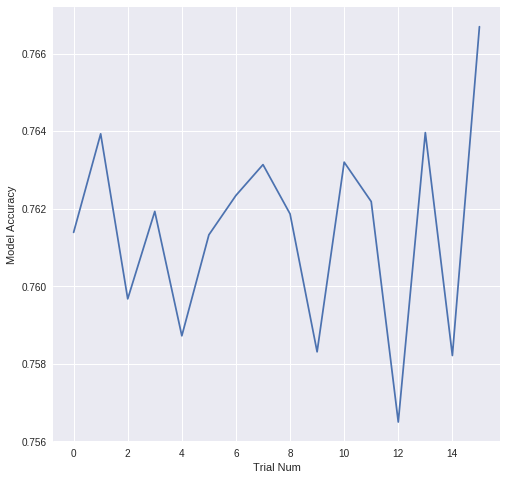

In [10]:
model1 = LinearSVC(penalty='l2', loss='hinge', dual=True, tol=0.00001, C=0.1, random_state=42, max_iter=1500)
model = CalibratedClassifierCV(model1, cv=5, method='isotonic')

categories=['Wins','PPG','PPGA','PowerConf','3PG', 'APG','TOP','Seed','SOS',\
            'SRS', 'RPG', 'SPG', 'Tourney Appearances','Location']
accuracy=[]
num_trials = 16

for i in range(num_trials):
    X_train, X_test, y_train, y_test = train_test_split(xTrain, yTrain)
    results = model.fit(X_train, y_train)
    preds = model.predict(X_test)

    preds[preds < .5] = 0
    preds[preds >= .5] = 1
    local_accuracy = np.mean(preds == y_test)
    accuracy.append(local_accuracy)
    print("Finished run #" + str(i) + ". Accuracy = " + str(local_accuracy))
print("The average accuracy is: ", sum(accuracy)/len(accuracy))

#Plot the accuracy.
plt.figure(figsize=(8, 8))
plt.plot(accuracy)
plt.xlabel("Trial Num")
plt.ylabel("Model Accuracy")

def predict_game(team_1_vector, team_2_vector, home):
    diff = [a - b for a, b in zip(team_1_vector, team_2_vector)]
    diff.append(home)
    # Depending on the model you use, you will either need to return model.predict_proba or model.predict
    # predict_proba = Linear Reg, Linear SVC
    # predict = Gradient Boosted

    return model.predict_proba([diff])[0][1]
    #return model.predict([diff])[0]
    
def load_team_vectors(years):
    list_dictionaries = []
    for year in years:
        current_vectors = np.load("./Team_Vectors/" + str(year) + "TeamVectors.npy").item()
        list_dictionaries.append(current_vectors)
    return list_dictionaries

def create_prediction(stage_2 = False):
    #this will allow us to submit predictions for just 2018
    if stage_2:
        
        years = [2018]
        new_submission = submission_stage_2
    #this will allow us to submit predictions for 2014-2017  
    else:
        years = range(2014, 2018)
        new_submission = submission
    
    if os.path.exists("result.csv"):
        os.remove("result.csv")
    
    list_dictionaries = load_team_vectors(years)
    print ("Loaded the team vectors")
    results = [[0 for x in range(2)] for x in range(len(new_submission.index))]
    
    for index, row in new_submission.iterrows():
        matchup = row['ID']
        year = int(matchup[0:4])
        team_vectors = list_dictionaries[year - years[0]]
        team_1_ID = int(matchup[5:9])
        team_2_ID = int(matchup[10:14])
        team_1_vector = team_vectors[team_1_ID]
        team_2_vector = team_vectors[team_2_ID]
        pred = predict_game(team_1_vector, team_2_vector, 0)
        results[index][0] = matchup
        results[index][1] = pred
    results = pd.np.array(results)
    first_row = [[0 for x in range(2)] for x in range(1)]
    first_row[0][0] = 'ID'
    first_row[0][1] = 'Pred'
    with open("result_svc_2018.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(first_row)
        writer.writerows(results)

create_prediction(stage_2=True)